In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime #Monday's weekday is 0
from matplotlib import pyplot as plt
import seaborn as sns
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn import metrics

#import datasets
train = pd.read_csv('./input/train_subsampled.csv')
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

#rmsle (taken from https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)
def rmsle(y, h): #changed the order to make it consistent with other sklearn metrics
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [2]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



1. **Feature Engineering** - (Rescaling lat and long feats and adding weekday and hour feats)

In [3]:
# build scalers, use both dropoff and pickup locations for this (hence the append)
latitude_scaler = preprocessing.StandardScaler().fit(
        train.dropoff_latitude.append(
                train.pickup_latitude).values.reshape(-1,1))

longitude_scaler = preprocessing.StandardScaler().fit(
        train.dropoff_longitude.append(
                train.pickup_longitude).values.reshape(-1,1))

# Creating three new features: weekday, hour and trip duration and add them to an engineered dataset.
 # Do this inside a function so we don't have to repeat it to the test set
def append_features(dataset):
    #drop some unnecessary columns if they exist
    columns_to_be_dropped = [ i for i in ['Unnamed: 0','id','vendor_id'] if i in dataset.columns]
    dataset_eng = dataset.copy().drop(columns_to_be_dropped, axis=1)
    #Create time features (hour and weekday)
    dataset_eng['pickup_datetime'] = dataset_eng.pickup_datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    dataset_eng['pickup_weekday'] = dataset_eng.pickup_datetime.apply(datetime.weekday)
    dataset_eng['pickup_hour'] = dataset_eng.pickup_datetime.apply(lambda x: x.hour)
    #rescale pickup locations
    dataset_eng['pickup_latitude'] = latitude_scaler.transform(dataset_eng.pickup_latitude.values.reshape(-1,1))
    dataset_eng['pickup_longitude'] = longitude_scaler.transform(dataset_eng.pickup_longitude.values.reshape(-1,1))
    #rescale dropoff locations
    dataset_eng['dropoff_latitude'] = latitude_scaler.transform(dataset_eng.dropoff_latitude.values.reshape(-1,1))
    dataset_eng['dropoff_longitude'] = longitude_scaler.transform(dataset_eng.dropoff_longitude.values.reshape(-1,1))
    #calculate rescaled distance
    dataset_eng['distance'] = np.sqrt( 
                                    (dataset_eng.dropoff_latitude - dataset_eng.pickup_latitude).pow(2) + 
                                    (dataset_eng.dropoff_longitude - dataset_eng.pickup_longitude).pow(2) )
    #the following features only apply for the training set
    if 'dropoff_datetime' in dataset.columns:
        dataset_eng['dropoff_datetime'] = dataset_eng.dropoff_datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    return dataset_eng

In [4]:
train_eng = append_features(train)
test_eng = append_features(test)
train_eng.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,-4.970701e-04,-1.276244e-02,4.970701e-04,1.276244e-02,9.594923e+02,3.050375e+00,1.360648e+01,7.670037e-01
std,1.314242e+00,1.001825e+00,9.552495e-01,9.981716e-01,1.042676e+00,5.237432e+03,1.954039e+00,6.399693e+00,9.277614e-01
min,0.000000e+00,-6.776612e+02,-1.856878e+02,-6.776607e+02,-2.489782e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,-2.602126e-01,-4.071157e-01,-2.525587e-01,-4.495886e-01,3.970000e+02,1.000000e+00,9.000000e+00,2.716031e-01
50%,1.000000e+00,-1.171601e-01,7.961833e-02,-8.902393e-02,9.191967e-02,6.620000e+02,3.000000e+00,1.400000e+01,4.763743e-01
75%,2.000000e+00,8.647679e-02,4.938743e-01,1.474924e-01,5.359869e-01,1.075000e+03,5.000000e+00,1.900000e+01,9.164467e-01
max,9.000000e+00,1.785707e+02,3.233358e+02,1.785707e+02,9.208377e+01,3.526282e+06,6.000000e+00,2.300000e+01,3.237857e+02


#### Distribution of trips per duration

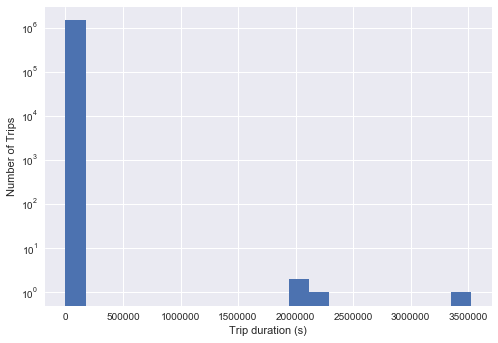

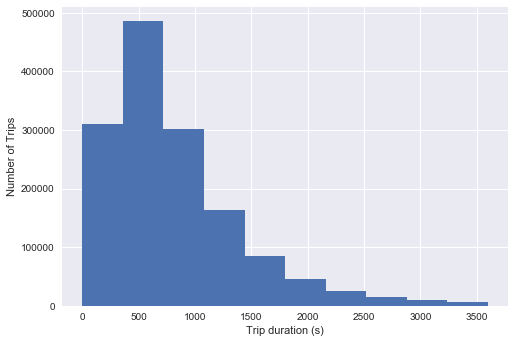

In [5]:
fig1 = train_eng.trip_duration.hist(bins = 20,log=True)
fig1.set_xlabel("Trip duration (s)")
fig1.set_ylabel("Number of Trips")
plt.show()

fig2 = train_eng[train_eng['trip_duration']<3600*1].trip_duration.hist()
fig2.set_xlabel("Trip duration (s)")
fig2.set_ylabel("Number of Trips")
plt.show()

In [6]:
## Function that receives a column of values already grouped by weekday and hour and aggregated, and plots the heat map
def plot_per_weekday_hour(aggregated_data, title = '' ):
    fig = sns.heatmap(aggregated_data.values.reshape((7,24)), cmap = 'jet')
    fig.set_xlabel('Hour')
    fig.set_ylabel('Day of the week')
    fig.set_title(title)
    plt.show()
    
#keep only trips that took less than 1 hour
aggregated_set = train_eng[train_eng['trip_duration']<3600*1].groupby(['pickup_weekday','pickup_hour'])

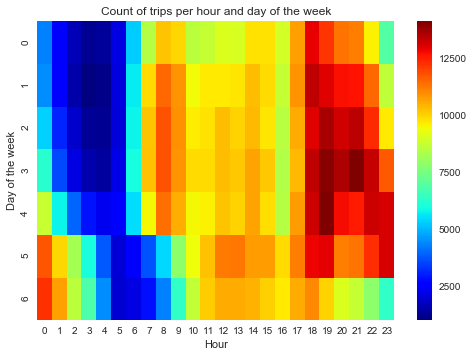

In [7]:

plot_per_weekday_hour(aggregated_set.count().distance, 
                      'Count of trips per hour and day of the week')

Most busy hours are between 17-24h on every day of the week except for Sundays

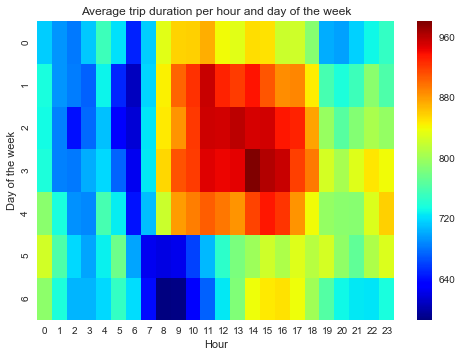

In [8]:
plot_per_weekday_hour(aggregated_set.mean().trip_duration, 
                      'Average trip duration per hour and day of the week')

Longest trips happen from Tuesday to Friday between 10 and 17h (perhaps due to traffic?)

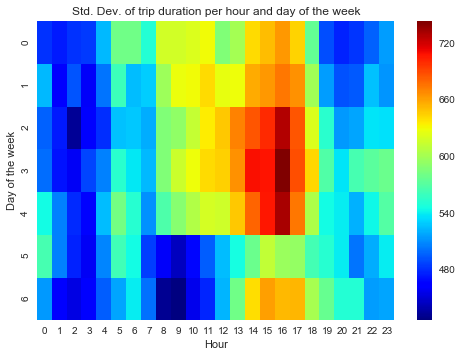

In [9]:
plot_per_weekday_hour(aggregated_set.std().trip_duration, 
                      'Std. Dev. of trip duration per hour and day of the week')

### Clustering by dropoff and pickup positions, hour and day of the week

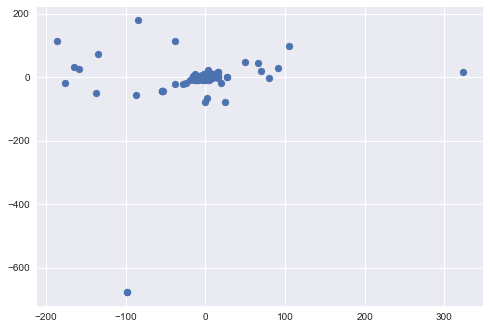

In [10]:
plt.scatter(train_eng.pickup_latitude, train_eng.pickup_longitude)
plt.show()

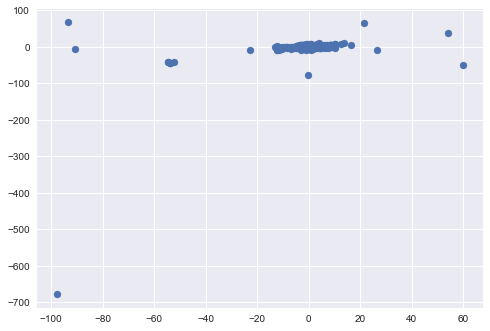

In [11]:
plt.scatter(test_eng.pickup_latitude, test_eng.pickup_longitude)
plt.show()

Some trips are way more distant and take longer than the rest so it won't be possible to obtain an accurate estimate from their neighbors, i.e clustering won't work for these ones...

Perhaps linear regression could be more useful in these cases!

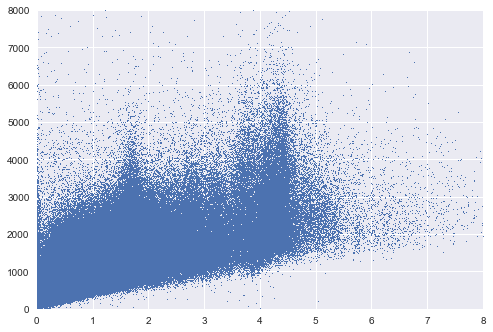

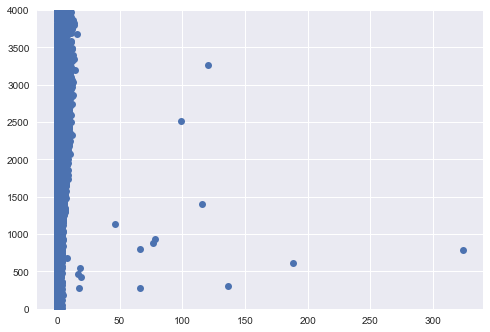

In [42]:
ax = plt.plot(train_eng.distance, train_eng.trip_duration,',')
plt.xlim(0,8)
plt.ylim(0,8000)
plt.show()

ax = plt.plot(train_eng.distance, train_eng.trip_duration,'o')
plt.ylim(0,4000)
plt.show()

##### Keep only interesting trips (the ones that took under 2h)

In [12]:
short_trips = train_eng[(train_eng.trip_duration < 3600*2) & (train_eng.distance < 8)]

In [13]:
short_trips.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,distance
count,1.456097e+06,1.456097e+06,1.456097e+06,1.456097e+06,1.456097e+06,1.456097e+06,1.456097e+06,1.456097e+06,1.456097e+06
mean,1.663953e+00,-9.653801e-04,-1.226273e-02,4.144964e-04,1.195995e-02,8.355489e+02,3.050012e+00,1.360638e+01,7.636963e-01
std,1.313648e+00,9.939117e-01,8.888820e-01,9.761805e-01,9.991333e-01,6.530834e+02,1.954000e+00,6.399397e+00,8.294643e-01
min,0.000000e+00,-6.776612e+02,-1.856878e+02,-6.776607e+02,-1.856878e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,-2.602126e-01,-4.065616e-01,-2.525587e-01,-4.494501e-01,3.970000e+02,1.000000e+00,9.000000e+00,2.715382e-01
50%,1.000000e+00,-1.171601e-01,7.983998e-02,-8.913173e-02,9.180885e-02,6.610000e+02,3.000000e+00,1.400000e+01,4.761392e-01
75%,2.000000e+00,8.626119e-02,4.938743e-01,1.472768e-01,5.356545e-01,1.072000e+03,5.000000e+00,1.900000e+01,9.155830e-01
max,9.000000e+00,1.785707e+02,9.181459e+01,1.785707e+02,9.181459e+01,7.191000e+03,6.000000e+00,2.300000e+01,7.989333e+00


In [14]:
X = short_trips[[
    'pickup_hour', 
    'pickup_weekday',
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude']].values

X = X*[5,100,1,1,1,1]
y = short_trips['trip_duration'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.10, random_state=42)

In [38]:
def evaluate(y_test, y_pred):
    print("Mean Absolute Error: {}".format(metrics.mean_absolute_error(y_test, y_pred)))
    print("Mean Squared Logarithmic Error: {}".format(rmsle(y_test, y_pred)))
    print("R2: {}".format(metrics.r2_score(y_test,y_pred)))
    fig2 = plt.plot(y_test,y_pred,'.',[0,6000],[0,6000],'r--')
    plt.xlabel('Actual duration (s)')
    plt.ylabel('Predicted duration (s)')
    plt.show()

Mean Absolute Error: 204.78042716846372
Mean Squared Logarithmic Error: 0.4296198837697357
R2: 0.7546222221787796


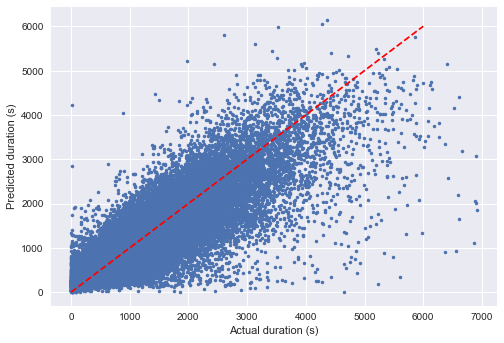

In [39]:
neigh = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
neigh.fit(X_train, y_train)
y_pred = np.int64(neigh.predict(X_test).round())

evaluate(y_test, y_pred)

Bela m*******

In [40]:
X = short_trips[[
    'pickup_hour', 
    'pickup_weekday',
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude']].values

X = X*[1/2.4,1,1,1,1,1]
y = short_trips['trip_duration'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.10, random_state=42)

Mean Absolute Error: 197.41496463155002
Mean Squared Logarithmic Error: 0.42438124805138805
R2: 0.7721387573262756


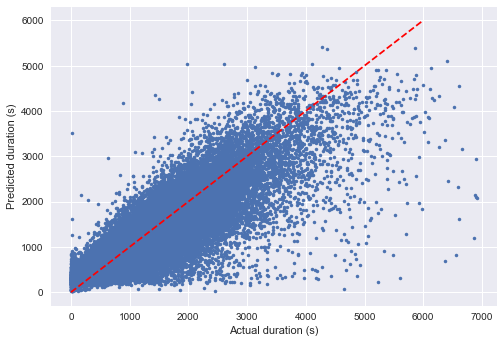

In [41]:
neigh = KNeighborsRegressor(n_neighbors=20, weights = 'distance')
neigh.fit(X_train, y_train)
y_pred = np.int64(neigh.predict(X_test).round())

evaluate(y_test, y_pred)

[1/24,1/6,1,1,1,1], n=10 -> R2:0.77373632
[1/24,1/6,1,1,1,1], n=15 -> R2:0.7777...
[1/24,1/6,1,1,1,1], n=20 -> R2:0.77881081
[1/24,1/6,1,1,1,1], n=30 -> R2:0.77852996